In [1]:
import glob
import numpy as np
import hyss_util as hu
from datetime import datetime
from sklearn.model_selection import train_test_split
from plotting import set_defaults
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy import stats
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [2]:
# -- set the types

kind = "veg"
comp = "bld"

In [3]:
# -- get wavelengths
waves = hu.read_header("../../../image_files/veg_00000.hdr")["waves"]

# -- define good scans
good = np.array([int(i) for i in np.load("../../../gdobler_output/output/good_scans.npy")])

reading and parsing ../../../image_files/veg_00000.hdr...


In [4]:
# -- get vegetation spectra
print("getting {0} spectra...".format(kind))
if kind=="veg":
    vegs = np.load("../../../gdobler_output/output/veg_patch_specs.npy")
else:
    vegs = np.array([np.load(i) for i in
                     sorted(glob.glob("../../../gdobler_output/output/" + 
                                      "{0}_specs/{0}_specs_avg*.npy" \
                                      .format(kind)))])
    vegs = vegs[good]

getting veg spectra...


In [5]:
# -- load comparison set from bld
print("getting {0} spectra...".format(comp))
#try:
#    blds_left = np.load("../../../gdobler_output/output/blds_left.npy")
#except:
blds = np.array([np.load(i) for i in
                sorted(glob.glob("../../../gdobler_output/output/{0}_specs/{0}_specs_avg*.npy"\
                                .format(comp)))])
blds = blds[good]
# np.save("../../../gdobler_output/output/blds_left.npy",blds)

getting bld spectra...


In [6]:
def normalize_spectra(specs):
    ms, bs = [], []
    for ii in range(specs.shape[0]):
        m = specs[0].mean()/specs[ii].mean()
        b = 0.0
        ms.append(m)
        bs.append(b)
        
    ms   = np.array(ms)
    bs   = np.array(bs)
    norm = specs*ms[:,np.newaxis] + bs[:,np.newaxis]
    rat  = norm/norm[0]
    return rat

In [7]:
# -- normalize spectra

vrat = normalize_spectra(vegs)
brat = normalize_spectra(blds)

In [8]:
print(vrat.shape, brat.shape)

(1102, 848) (1102, 848)


In [9]:
# -- take the ratio of ratios
D_vrat = vrat/brat   # vegetation to buildings
print(D_vrat.shape)

# -- normalize differential ratios
#Dn_vrat = stats.zscore(D_vrat)

(1102, 848)


#### Get air quality data

In [10]:
# -- get some ancillary data
sc     = pd.read_csv("../../../gdobler_output/output/scan_conditions.csv")
sc_sub = sc[sc.filename.isin(["veg_{0:05}.raw".format(i) for i in good])]

temps = sc_sub.temperature.values
humid = sc_sub.humidity.values
pm25  = sc_sub.pm25.values
o3    = sc_sub.o3.values
secs  = []
for stime in sc_sub.time.values:
    yr, mo, dy, tm = stime.split()
    stime_fmt      = "{0} {1} {2:02} {3}:00".format(yr,mo,int(dy),tm)
    obs_dt         = datetime.strptime(stime_fmt,"%Y %b %d %H:%M:%S")
    secs.append(float(obs_dt.strftime("%s")))
secs = np.array(secs)

In [11]:
opth = pd.DataFrame({'$O_3$': o3, '$PM_{2.5}$': pm25, 'Temperature': temps, 'Humidity':humid})
opth.describe()

,$O_3$,$PM_{2.5}$,Humidity,Temperature
count,1102.000000,1102.000000,1102.000000,1102.000000
mean,0.038318,6.198070,54.506352,68.924592
std,0.014651,3.558875,25.721231,10.497654
min,0.005500,-0.362000,18.000000,46.900000
25%,0.026250,3.569470,33.000000,61.900000
50%,0.038500,5.581250,47.000000,69.100000
75%,0.046500,8.316667,75.000000,76.100000
max,0.086500,17.365833,99.000000,94.500000


Text(0.5,0.95,'Air Quality Scatter Matrix')

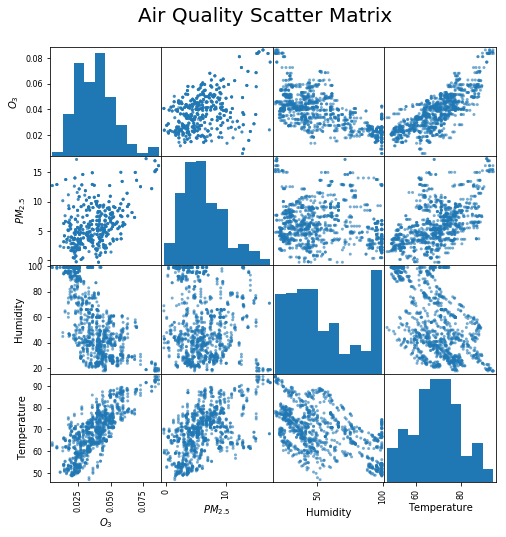

In [12]:
plt.rcParams['font.size'] = 10
#fig, ax = plt.subplots(figsize=[10,10])
mtx = scatter_matrix(opth, alpha=0.6, figsize=(8,8), diagonal='hist')
plt.suptitle("Air Quality Scatter Matrix", y=0.95, fontsize=20)
#plt.savefig("../farid_output/air_quality_scatter_matrix.pdf", dpi=300)
#plt.savefig("../farid_output/air_quality_scatter_matrix.png", dpi=300)

In [13]:
#normalize air quality arrays

o3 = stats.zscore(o3)
pm25 = stats.zscore(pm25)
temps = stats.zscore(temps)
humid = stats.zscore(humid)

aq_opth = np.vstack((o3, pm25, temps, humid)).T
print(aq_opth.shape)

(1102, 4)


In [14]:
# create air quality array

aq_opth = np.vstack((o3, pm25, temps, humid)).T
print(aq_opth.shape)

(1102, 4)


### Split data into train/test sets

In [15]:
Dtrain, Dtest, aqtrain, aqtest = train_test_split(D_vrat, aq_opth, test_size=0.2)

---

## CNN

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers

In [17]:
def CNN_model(in_dim, out_dim, filtersize=50):
    Inputs = keras.Input(shape=(in_dim, 1), name="input_diffratio")
    
    Conv1D_1 = layers.Conv1D(16, kernel_size=(filtersize), padding="same", activation="relu")(Inputs)
    MaxPool_1 = layers.MaxPooling1D((2), strides=2)(Conv1D_1)
    Conv1D_2 = layers.Conv1D(32, kernel_size=(filtersize), padding="same", activation="relu")(MaxPool_1)
    MaxPool_2 = layers.MaxPooling1D((2), strides=2)(Conv1D_2)
    
    #Flatten = layers.Flatten()(MaxPool_2)
    Dropout = layers.Dropout(0.5)(MaxPool_2)
    Flatten = layers.Flatten()(Dropout)
    
    Dense = layers.Dense(512, activation="relu")(Flatten)
    Outputs = layers.Dense(out_dim)(Dense)
    
    model = keras.Model(inputs=[Inputs], outputs=[Outputs])
    
    return model

In [18]:
def plot_loss_history(model):
    f, ((ax1, ax2)) = plt.subplots(1,2,figsize=(10,4))
    ax1.plot(model.history['loss'])
    ax1.plot(model.history['val_loss'])
    ax1.set_title('CNN Model Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.locator_params(nbins=13, axis='x')
    ax1.legend(['train', 'test'])
    ax2.plot(model.history['loss'])
    ax2.plot(model.history['val_loss'])
    ax2.set_title('CNN Model Log(loss)')
    ax2.set_ylabel('log(loss)')
    ax2.set_xlabel('epoch')
    ax2.locator_params(nbins=13, axis='x')
    ax2.legend(['train', 'test'])
    ax2.set_yscale('log')
    plt.show()

In [19]:
in_dim = D_vrat.shape[1]
out_dim = aq_opth.shape[1]
cnn = CNN_model(in_dim, out_dim, filtersize=50)
cnn.compile(optimizer="adam", loss="mse")

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [20]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_diffratio (InputLayer) (None, 848, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 848, 16)           816       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 424, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 424, 32)           25632     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 212, 32)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 212, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6784)              0         
__________

In [21]:
Dtrain_1 = Dtrain.reshape(Dtrain.shape[0], Dtrain.shape[1], 1)
Dtest_1 = Dtest.reshape(Dtest.shape[0], Dtest.shape[1], 1)

In [22]:
cnn1 = CNN_model(in_dim, out_dim, filtersize=50)
cnn1.compile(optimizer="adam", loss="mse")
CNNmodel1 = cnn1.fit(Dtrain_1, aqtrain, validation_data=(Dtest_1, aqtest),
                  epochs=1000, batch_size=120)

Train on 881 samples, validate on 221 samples
Epoch 1/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.9563 - val_loss: 1.0678
Epoch 2/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.8116 - val_loss: 0.9300
Epoch 3/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.7208 - val_loss: 1.0053
Epoch 4/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.7062 - val_loss: 0.7888
Epoch 5/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.6334 - val_loss: 0.7093
Epoch 6/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.6088 - val_loss: 0.6978
Epoch 7/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.5907 - val_loss: 0.7011
Epoch 8/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.5766 - val_loss: 0.6529
Epoch 9/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.5429 - val_loss: 0.6206
Epoch 10/1000
881/881 [=============

881/881 [==============================] - 1s 1ms/step - loss: 0.2699 - val_loss: 0.2674
Epoch 81/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2625 - val_loss: 0.2561
Epoch 82/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2637 - val_loss: 0.2972
Epoch 83/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2771 - val_loss: 0.2800
Epoch 84/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2728 - val_loss: 0.2973
Epoch 85/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2750 - val_loss: 0.2552
Epoch 86/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2640 - val_loss: 0.2575
Epoch 87/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2509 - val_loss: 0.2507
Epoch 88/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2560 - val_loss: 0.2807
Epoch 89/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2494 - v

881/881 [==============================] - 1s 2ms/step - loss: 0.1853 - val_loss: 0.1954
Epoch 160/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1792 - val_loss: 0.1938
Epoch 161/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1756 - val_loss: 0.1945
Epoch 162/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1769 - val_loss: 0.1921
Epoch 163/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1791 - val_loss: 0.1872
Epoch 164/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1758 - val_loss: 0.1955
Epoch 165/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1712 - val_loss: 0.1965
Epoch 166/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1781 - val_loss: 0.1971
Epoch 167/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1854 - val_loss: 0.1912
Epoch 168/1000
881/881 [==============================] - 1s 1ms/step - loss: 0

Epoch 238/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1338 - val_loss: 0.1710
Epoch 239/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1316 - val_loss: 0.1807
Epoch 240/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1315 - val_loss: 0.1841
Epoch 241/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1389 - val_loss: 0.1800
Epoch 242/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1447 - val_loss: 0.1919
Epoch 243/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1306 - val_loss: 0.1759
Epoch 244/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1266 - val_loss: 0.1734
Epoch 245/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1293 - val_loss: 0.1735
Epoch 246/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1270 - val_loss: 0.1765
Epoch 247/1000
881/881 [==============================] - 1s 1ms

Epoch 317/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1071 - val_loss: 0.1713
Epoch 318/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1104 - val_loss: 0.1629
Epoch 319/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1178 - val_loss: 0.1823
Epoch 320/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1118 - val_loss: 0.1759
Epoch 321/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1058 - val_loss: 0.1652
Epoch 322/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1101 - val_loss: 0.1669
Epoch 323/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1213 - val_loss: 0.1814
Epoch 324/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1227 - val_loss: 0.1616
Epoch 325/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1084 - val_loss: 0.1716
Epoch 326/1000
881/881 [==============================] - 1s 1ms

Epoch 396/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0868 - val_loss: 0.1655
Epoch 397/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0839 - val_loss: 0.1530
Epoch 398/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0837 - val_loss: 0.1576
Epoch 399/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0852 - val_loss: 0.1551
Epoch 400/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0869 - val_loss: 0.1610
Epoch 401/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0837 - val_loss: 0.1565
Epoch 402/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0880 - val_loss: 0.1587
Epoch 403/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0844 - val_loss: 0.1517
Epoch 404/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0809 - val_loss: 0.1514
Epoch 405/1000
881/881 [==============================] - 1s 1ms

Epoch 475/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0768 - val_loss: 0.1588
Epoch 476/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0819 - val_loss: 0.1578
Epoch 477/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0821 - val_loss: 0.1632
Epoch 478/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0730 - val_loss: 0.1709
Epoch 479/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0894 - val_loss: 0.1656
Epoch 480/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0795 - val_loss: 0.1562
Epoch 481/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0866 - val_loss: 0.1552
Epoch 482/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0745 - val_loss: 0.1472
Epoch 483/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0726 - val_loss: 0.1564
Epoch 484/1000
881/881 [==============================] - 2s 2ms

Epoch 554/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0667 - val_loss: 0.1526
Epoch 555/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0708 - val_loss: 0.1565
Epoch 556/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0709 - val_loss: 0.1555
Epoch 557/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0713 - val_loss: 0.1504
Epoch 558/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0668 - val_loss: 0.1516
Epoch 559/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0648 - val_loss: 0.1492
Epoch 560/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0620 - val_loss: 0.1521
Epoch 561/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0638 - val_loss: 0.1572
Epoch 562/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0709 - val_loss: 0.1548
Epoch 563/1000
881/881 [==============================] - 1s 1ms

Epoch 633/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0577 - val_loss: 0.1546
Epoch 634/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0564 - val_loss: 0.1550
Epoch 635/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0601 - val_loss: 0.1448
Epoch 636/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0590 - val_loss: 0.1580
Epoch 637/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0588 - val_loss: 0.1493
Epoch 638/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0646 - val_loss: 0.1518
Epoch 639/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0577 - val_loss: 0.1505
Epoch 640/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0584 - val_loss: 0.1434
Epoch 641/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0568 - val_loss: 0.1593
Epoch 642/1000
881/881 [==============================] - 2s 2ms

Epoch 712/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0525 - val_loss: 0.1493
Epoch 713/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0549 - val_loss: 0.1515
Epoch 714/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0504 - val_loss: 0.1502
Epoch 715/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0506 - val_loss: 0.1535
Epoch 716/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0497 - val_loss: 0.1469
Epoch 717/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0527 - val_loss: 0.1476
Epoch 718/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0540 - val_loss: 0.1579
Epoch 719/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0540 - val_loss: 0.1468
Epoch 720/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0563 - val_loss: 0.1633
Epoch 721/1000
881/881 [==============================] - 2s 2ms

Epoch 791/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0494 - val_loss: 0.1435
Epoch 792/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0500 - val_loss: 0.1453
Epoch 793/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0498 - val_loss: 0.1497
Epoch 794/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0459 - val_loss: 0.1464
Epoch 795/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0507 - val_loss: 0.1484
Epoch 796/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0474 - val_loss: 0.1500
Epoch 797/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0516 - val_loss: 0.1455
Epoch 798/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0471 - val_loss: 0.1518
Epoch 799/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0465 - val_loss: 0.1477
Epoch 800/1000
881/881 [==============================] - 1s 2ms

Epoch 870/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0641 - val_loss: 0.1671
Epoch 871/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0625 - val_loss: 0.1569
Epoch 872/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0568 - val_loss: 0.1564
Epoch 873/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0497 - val_loss: 0.1613
Epoch 874/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0486 - val_loss: 0.1569
Epoch 875/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0457 - val_loss: 0.1556
Epoch 876/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0443 - val_loss: 0.1493
Epoch 877/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0466 - val_loss: 0.1516
Epoch 878/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0442 - val_loss: 0.1468
Epoch 879/1000
881/881 [==============================] - 1s 2ms

Epoch 949/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0410 - val_loss: 0.1505
Epoch 950/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0384 - val_loss: 0.1518
Epoch 951/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0369 - val_loss: 0.1489
Epoch 952/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0361 - val_loss: 0.1476
Epoch 953/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0383 - val_loss: 0.1521
Epoch 954/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0388 - val_loss: 0.1477
Epoch 955/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0362 - val_loss: 0.1514
Epoch 956/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0384 - val_loss: 0.1476
Epoch 957/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0379 - val_loss: 0.1589
Epoch 958/1000
881/881 [==============================] - 2s 2ms

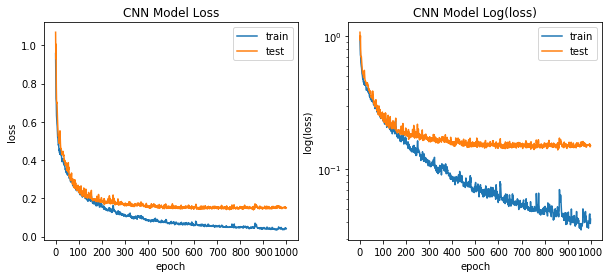

In [23]:
plot_loss_history(CNNmodel1)

In [24]:
cnn = CNN_model(in_dim, out_dim, filtersize=50)
cnn.compile(optimizer="adam", loss="mse")
CNNmodel = cnn.fit(Dtrain_1, aqtrain, validation_data=(Dtest_1, aqtest),
                  epochs=200, batch_size=120)

Train on 881 samples, validate on 221 samples
Epoch 1/200
881/881 [==============================] - 3s 3ms/step - loss: 1.3484 - val_loss: 1.1399
Epoch 2/200
881/881 [==============================] - 2s 2ms/step - loss: 0.9648 - val_loss: 1.1406
Epoch 3/200
881/881 [==============================] - 2s 2ms/step - loss: 0.9598 - val_loss: 1.1402
Epoch 4/200
881/881 [==============================] - 2s 2ms/step - loss: 0.9590 - val_loss: 1.1187
Epoch 5/200
881/881 [==============================] - 2s 2ms/step - loss: 0.9210 - val_loss: 1.0551
Epoch 6/200
881/881 [==============================] - 2s 2ms/step - loss: 0.8487 - val_loss: 0.9913
Epoch 7/200
881/881 [==============================] - 2s 2ms/step - loss: 0.7992 - val_loss: 0.9915
Epoch 8/200
881/881 [==============================] - 2s 2ms/step - loss: 0.7995 - val_loss: 0.8982
Epoch 9/200
881/881 [==============================] - 2s 2ms/step - loss: 0.7513 - val_loss: 0.9712
Epoch 10/200
881/881 [=======================

Epoch 81/200
881/881 [==============================] - 1s 2ms/step - loss: 0.4186 - val_loss: 0.4626
Epoch 82/200
881/881 [==============================] - 1s 2ms/step - loss: 0.4328 - val_loss: 0.4255
Epoch 83/200
881/881 [==============================] - 1s 2ms/step - loss: 0.4242 - val_loss: 0.4405
Epoch 84/200
881/881 [==============================] - 1s 2ms/step - loss: 0.4190 - val_loss: 0.4373
Epoch 85/200
881/881 [==============================] - 1s 2ms/step - loss: 0.4121 - val_loss: 0.4312
Epoch 86/200
881/881 [==============================] - 1s 2ms/step - loss: 0.4213 - val_loss: 0.4248
Epoch 87/200
881/881 [==============================] - 2s 2ms/step - loss: 0.4049 - val_loss: 0.4411
Epoch 88/200
881/881 [==============================] - 1s 2ms/step - loss: 0.4177 - val_loss: 0.4783
Epoch 89/200
881/881 [==============================] - 2s 2ms/step - loss: 0.4244 - val_loss: 0.4257
Epoch 90/200
881/881 [==============================] - 2s 2ms/step - loss: 0.4145

881/881 [==============================] - 2s 2ms/step - loss: 0.3469 - val_loss: 0.3023
Epoch 161/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3366 - val_loss: 0.2944
Epoch 162/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3382 - val_loss: 0.3376
Epoch 163/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3323 - val_loss: 0.3476
Epoch 164/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3532 - val_loss: 0.3171
Epoch 165/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3387 - val_loss: 0.3428
Epoch 166/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3560 - val_loss: 0.3185
Epoch 167/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3243 - val_loss: 0.2905
Epoch 168/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3264 - val_loss: 0.3112
Epoch 169/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3149 - v

In [25]:
# model MSE on training and testing sets

train_mse = cnn.evaluate(Dtrain_1, aqtrain)
test_mse = cnn.evaluate(Dtest_1, aqtest)

print(train_mse, test_mse)

221/221 [==============================] - 0s 537us/step
0.23178300572713578 0.26773429281031924


### Predict Air Quality for training and Testing Sets

In [26]:
import time
start_time = time.time()

aqtrain_pred = cnn.predict(Dtrain_1)
aqtest_pred = cnn.predict(Dtest_1)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:00:00


In [27]:
print(aqtrain.shape)
print(aqtest.shape)

(881, 4)
(221, 4)


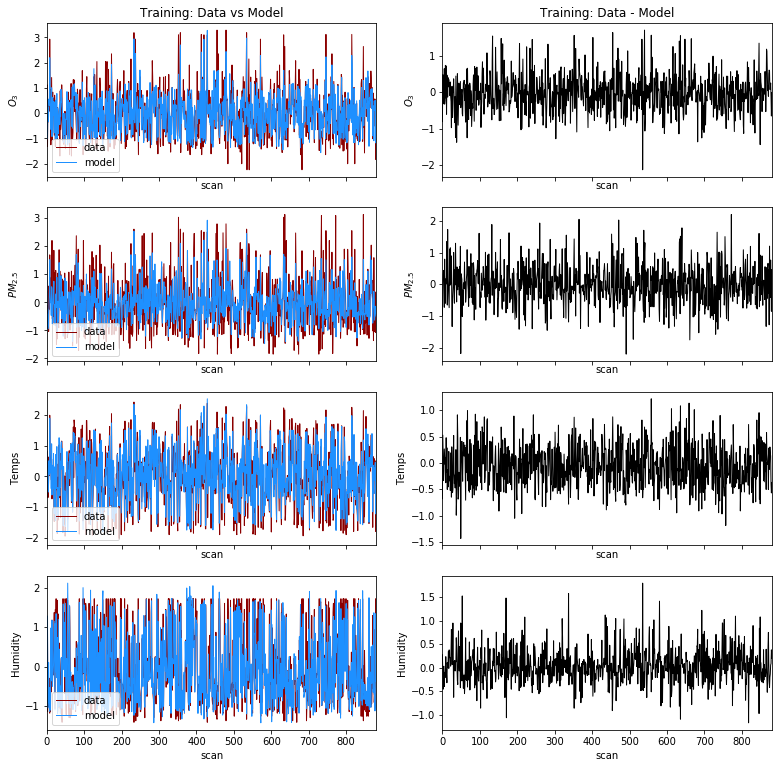

In [28]:
fig, axes = plt.subplots(aq_opth.shape[1], 2, figsize=(13, 13), sharex=True)
labels = [r'$O_3$', r'$PM_{2.5}$', 'Temps', 'Humidity']

axes[0,0].set_title('Training: Data vs Model')
for i in range(aq_opth.shape[1]):
    axes[i,0].plot(aqtrain[:,i], color="darkred",lw=1, label="data")
    axes[i,0].plot(aqtrain_pred[:,i], color="dodgerblue",lw=1, label="model")
    axes[i,0].set_ylabel(labels[i])
    axes[i,0].legend(loc='lower left')
    axes[i,0].set_xlabel("scan")
    axes[i,0].set_xlim(0, aqtrain.shape[0])

axes[0,1].set_title('Training: Data - Model')
for i in range(aq_opth.shape[1]):
    axes[i,1].plot(aqtrain[:,i] - aqtrain_pred[:,i], color="black",lw=1)
    #axes[i,1].plot(aqtrain_pred[:,i], color="dodgerblue",lw=1, label="model")
    axes[i,1].set_ylabel(labels[i])
    #axes[i,1].legend(loc='lower left')
    axes[i,1].set_xlabel("scan")
    axes[i,1].set_xlim(0, aqtrain.shape[0])
    
plt.show()

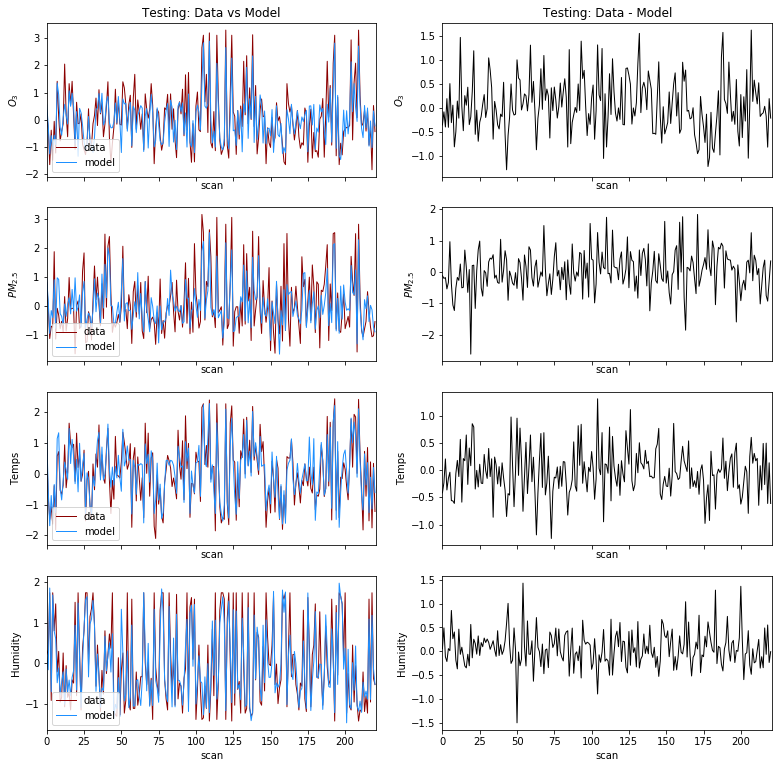

In [29]:
fig, axes = plt.subplots(aq_opth.shape[1], 2, figsize=(13, 13), sharex=True)
labels = [r'$O_3$', r'$PM_{2.5}$', 'Temps', 'Humidity']

axes[0,0].set_title('Testing: Data vs Model')
for i in range(aq_opth.shape[1]):
    axes[i,0].plot(aqtest[:,i], color="darkred",lw=1, label="data")
    axes[i,0].plot(aqtest_pred[:,i], color="dodgerblue",lw=1, label="model")
    axes[i,0].set_ylabel(labels[i])
    axes[i,0].legend(loc='lower left')
    axes[i,0].set_xlabel("scan")
    axes[i,0].set_xlim(0, aqtest.shape[0])

axes[0,1].set_title('Testing: Data - Model')
for i in range(aq_opth.shape[1]):
    axes[i,1].plot(aqtest[:,i] - aqtest_pred[:,i], color="black",lw=1)
    #axes[i,1].plot(aqtrain_pred[:,i], color="dodgerblue",lw=1, label="model")
    axes[i,1].set_ylabel(labels[i])
    #axes[i,1].legend(loc='lower left')
    axes[i,1].set_xlabel("scan")
    axes[i,1].set_xlim(0, aqtest.shape[0])
    
plt.show()

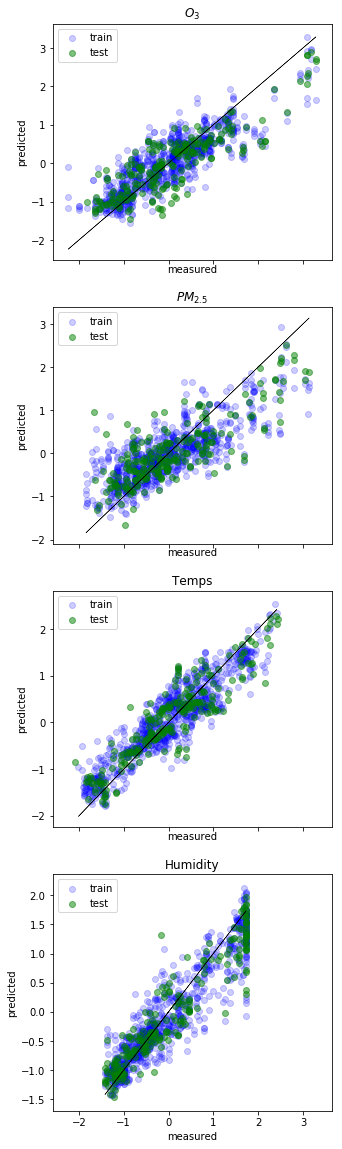

In [102]:
fig, ax = plt.subplots(aq_opth.shape[1], 1, figsize=(5, 20), sharex=True)
labels = [r'$O_3$', r'$PM_{2.5}$', 'Temps', 'Humidity']

for i in range(aq_opth.shape[1]):
    ax[i].set_title(labels[i])
    ax[i].plot(aqtrain[:,i], aqtrain[:,i], color='black', lw=0.5)
    ax[i].scatter(aqtrain[:,i], aqtrain_pred[:,i], c="blue", alpha=0.2, label="train")
    ax[i].scatter(aqtest[:,i], aqtest_pred[:,i], c="green", alpha=0.5, label="test")
    ax[i].set_ylabel('predicted')
    ax[i].set_xlabel('measured')
    ax[i].legend(loc='upper left')
    
plt.show()

---

# Smoothing Air Quality

In [30]:
# -- get some ancillary data
sc     = pd.read_csv("../../../gdobler_output/output/scan_conditions.csv")

In [31]:
DateTime = []
Date = []
Time = []
for stime in sc.time.values:
    yr, mo, dy, tm = stime.split()
    stime_fmt = "{0} {1} {2:02} {3}:00".format(yr,mo,int(dy),tm)
    obs_dt = datetime.strptime(stime_fmt,"%Y %b %d %H:%M:%S")
    DateTime.append(obs_dt)
    Date.append(datetime.date(obs_dt))
    Time.append(datetime.time(obs_dt))
    
sc['DateTime'] = DateTime
sc['Date'] = Date
sc['Time'] = Time

In [32]:
sc.head()

,Unnamed: 0,time,filename,temperature,dew_point,pressure,humidity,hourly_precipitation,pm25,o3,DateTime,Date,Time
0,0,2016 May 2 17:46,veg_00000.raw,61.5,53.9,29.71,76.0,-99.99,8.078333,0.01175,2016-05-02 17:46:00,2016-05-02,17:46:00
1,1,2016 May 2 18:01,veg_00001.raw,62.4,54.4,29.71,75.0,-99.99,8.078333,0.01175,2016-05-02 18:01:00,2016-05-02,18:01:00
2,2,2016 May 3 08:01,veg_00002.raw,53.2,52.9,29.67,99.0,-99.99,2.160833,0.01425,2016-05-03 08:01:00,2016-05-03,08:01:00
3,3,2016 May 3 08:16,veg_00003.raw,53.4,53.1,29.66,99.0,-99.99,2.160833,0.01425,2016-05-03 08:16:00,2016-05-03,08:16:00
4,4,2016 May 3 08:31,veg_00004.raw,53.8,53.5,29.66,99.0,-99.99,3.147500,0.01425,2016-05-03 08:31:00,2016-05-03,08:31:00


In [33]:
sc.groupby('Date')['Date'].count()

Date
2016-05-02     2
2016-05-03    41
2016-05-04    41
2016-05-05    41
2016-05-06    41
2016-05-07    41
2016-05-08    41
2016-05-09    41
2016-05-10    41
2016-05-11    41
2016-05-12    41
2016-05-13    41
2016-05-14    41
2016-05-15    41
2016-05-16    41
2016-05-17    41
2016-05-18    41
2016-05-19    41
2016-05-20    40
2016-05-21    41
2016-05-22    41
2016-05-23    41
2016-05-24    41
2016-05-25    41
2016-05-31    29
2016-06-01    41
2016-06-02    41
2016-06-03    41
2016-06-04    41
2016-06-05    41
2016-06-06    41
2016-06-07    41
2016-06-08    40
Name: Date, dtype: int64

In [66]:
sc.Date[.count()]

Timestamp('2016-05-02 17:46:00')

In [68]:
days=[sc.DateTime[0]]
for i in range(sc.Date.count()-1):
    if sc.Date[i] != sc.Date[i+1]:
        days.append(sc.DateTime[i+1])

print(days)

[Timestamp('2016-05-02 17:46:00'),
 Timestamp('2016-05-03 08:01:00'),
 Timestamp('2016-05-04 08:01:00'),
 Timestamp('2016-05-05 08:01:00'),
 Timestamp('2016-05-06 08:01:00'),
 Timestamp('2016-05-07 08:01:00'),
 Timestamp('2016-05-08 08:01:00'),
 Timestamp('2016-05-09 08:01:00'),
 Timestamp('2016-05-10 08:01:00'),
 Timestamp('2016-05-11 08:01:00'),
 Timestamp('2016-05-12 08:01:00'),
 Timestamp('2016-05-13 08:01:00'),
 Timestamp('2016-05-14 08:01:00'),
 Timestamp('2016-05-15 08:01:00'),
 Timestamp('2016-05-16 08:01:00'),
 Timestamp('2016-05-17 08:01:00'),
 Timestamp('2016-05-18 08:01:00'),
 Timestamp('2016-05-19 08:01:00'),
 Timestamp('2016-05-20 08:01:00'),
 Timestamp('2016-05-21 08:01:00'),
 Timestamp('2016-05-22 08:01:00'),
 Timestamp('2016-05-23 08:01:00'),
 Timestamp('2016-05-24 08:01:00'),
 Timestamp('2016-05-25 08:01:00'),
 Timestamp('2016-05-31 11:01:00'),
 Timestamp('2016-06-01 08:01:00'),
 Timestamp('2016-06-02 08:01:00'),
 Timestamp('2016-06-03 08:01:00'),
 Timestamp('2016-06-

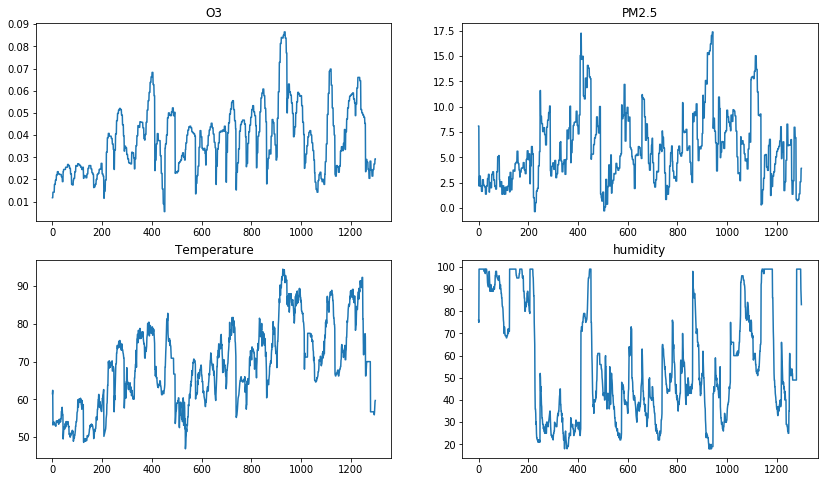

In [39]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(14,8))
ax1.plot(sc['o3'])
ax1.set_title('O3')
ax2.plot(sc['pm25'])
ax2.set_title('PM2.5')
ax3.plot(sc['temperature'])
ax3.set_title('Temperature')
ax4.plot(sc['humidity'])
ax4.set_title('humidity')

plt.show()

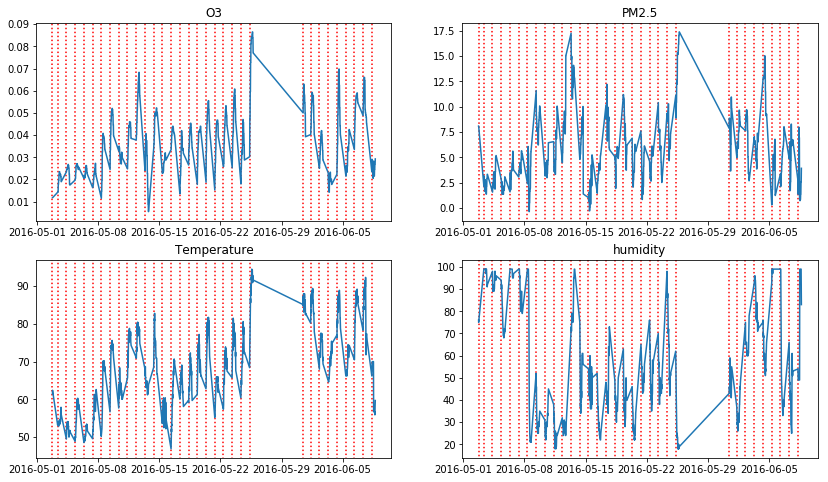

In [81]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(14,8))

ax1.plot(sc['DateTime'], sc['o3'])
ax1.set_ylim(ax1.get_ylim())
ax1.set_title('O3')
ax1.vlines(days, 0, 1, colors='r', linestyle='dotted')

ax2.plot(sc['DateTime'], sc['pm25'])
ax2.set_ylim(ax2.get_ylim())
ax2.set_title('PM2.5')
ax2.vlines(days, -5, 20, colors='r', linestyle='dotted')

ax3.plot(sc['DateTime'], sc['temperature'])
ax3.set_ylim(ax3.get_ylim())
ax3.set_title('Temperature')
ax3.vlines(days, 0, 100, colors='r', linestyle='dotted')

ax4.plot(sc['DateTime'], sc['humidity'])
ax4.set_ylim(ax4.get_ylim())
ax4.set_title('humidity')
ax4.vlines(days, -5, 120, colors='r', linestyle='dotted')

plt.show()

In [42]:
from scipy.ndimage import gaussian_filter1d

gO3 = np.array([])
gPM25 = np.array([])
gTemps = np.array([])
gHumid = np.array([])
for d in range(len(list(sc.groupby('Date')))):
    oz = list(sc.groupby('Date')['o3'])[d][1]
    gaussO = gaussian_filter1d(oz, 5)
    gO3 = np.append(gO3,gaussO)
    
    pm = list(sc.groupby('Date')['pm25'])[d][1]
    gaussP = gaussian_filter1d(pm, 5)
    gPM25 = np.append(gPM25,gaussP)
    
    temps = list(sc.groupby('Date')['temperature'])[d][1]
    gaussT = gaussian_filter1d(temps, 5)
    gTemps = np.append(gTemps,gaussT)
    
    hums = list(sc.groupby('Date')['humidity'])[d][1]
    gaussH = gaussian_filter1d(hums, 5)
    gHumid = np.append(gHumid,gaussH)

In [43]:
sc['gO3'] = gO3
sc['gPM25'] = gPM25
sc['gTemps'] = gTemps
sc['gHumid'] = gHumid

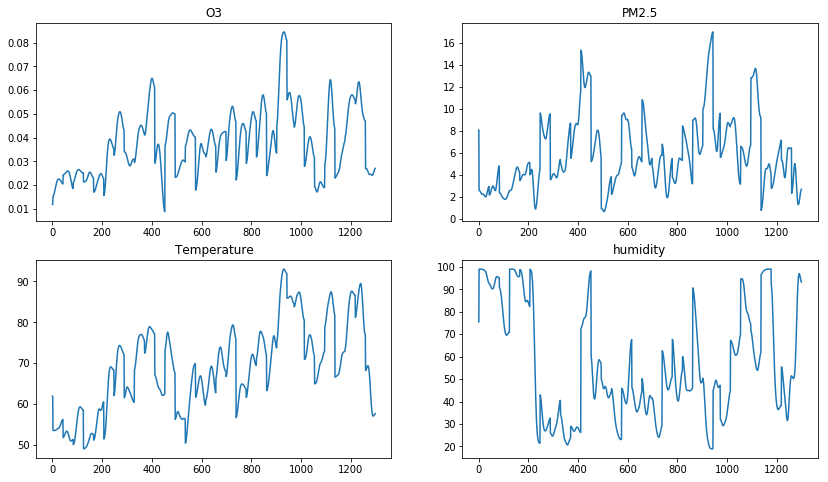

In [44]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(14,8))
ax1.plot(sc['gO3'])
ax1.set_title('O3')
ax2.plot(sc['gPM25'])
ax2.set_title('PM2.5')
ax3.plot(sc['gTemps'])
ax3.set_title('Temperature')
ax4.plot(sc['gHumid'])
ax4.set_title('humidity')

plt.show()

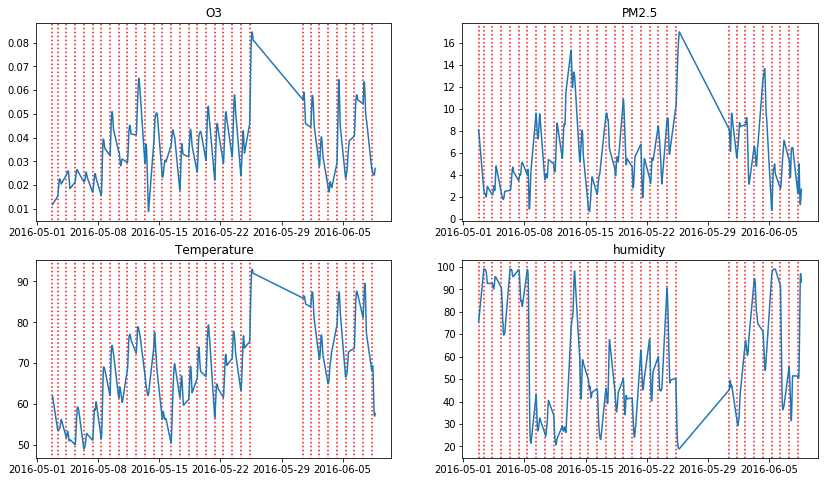

In [82]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(14,8))
ax1.plot(sc['DateTime'], sc['gO3'])
ax1.set_ylim(ax1.get_ylim())
ax1.set_title('O3')
ax1.vlines(days, 0, 1, colors='r', linestyle='dotted')

ax2.plot(sc['DateTime'], sc['gPM25'])
ax2.set_ylim(ax2.get_ylim())
ax2.set_title('PM2.5')
ax2.vlines(days, -5, 20, colors='r', linestyle='dotted')

ax3.plot(sc['DateTime'], sc['gTemps'])
ax3.set_ylim(ax3.get_ylim())
ax3.set_title('Temperature')
ax3.vlines(days, 0, 100, colors='r', linestyle='dotted')

ax4.plot(sc['DateTime'], sc['gHumid'])
ax4.set_ylim(ax4.get_ylim())
ax4.set_title('humidity')
ax4.vlines(days, -5, 120, colors='r', linestyle='dotted')

plt.show()

In [103]:
sc_sub = sc[sc.filename.isin(["veg_{0:05}.raw".format(i) for i in good])]

temps = sc_sub.gTemps.values
humid = sc_sub.gHumid.values
pm25  = sc_sub.gPM25.values
o3    = sc_sub.gO3.values

In [104]:
opth = pd.DataFrame({'$O_3$': o3, '$PM_{2.5}$': pm25, 'Temperature': temps, 'Humidity':humid})
opth.describe()

,$O_3$,$PM_{2.5}$,Humidity,Temperature
count,1102.000000,1102.000000,1102.000000,1102.000000
mean,0.038339,6.196070,54.479270,68.950684
std,0.013907,3.352738,25.089528,10.192208
min,0.008745,0.651073,18.918791,49.073279
25%,0.027882,3.822441,34.137445,62.390249
50%,0.037544,5.441123,46.458627,69.049929
75%,0.046620,8.305614,74.788930,75.924230
max,0.084589,17.012501,99.000000,92.998160


Text(0.5,0.95,'Air Quality Scatter Matrix')

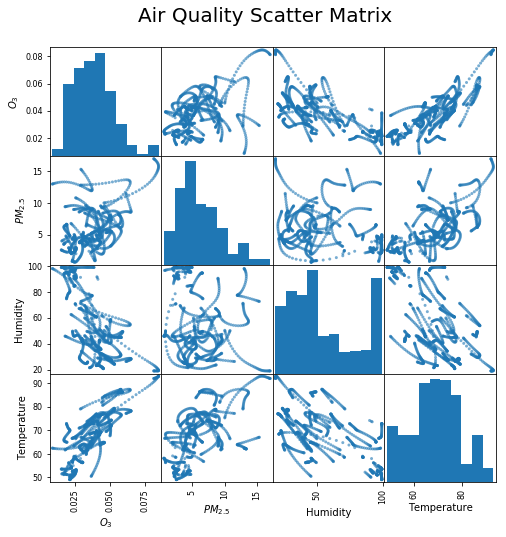

In [105]:
plt.rcParams['font.size'] = 10
#fig, ax = plt.subplots(figsize=[10,10])
mtx = scatter_matrix(opth, alpha=0.6, figsize=(8,8), diagonal='hist')
plt.suptitle("Air Quality Scatter Matrix", y=0.95, fontsize=20)
#plt.savefig("../farid_output/air_quality_scatter_matrix.pdf", dpi=300)
#plt.savefig("../farid_output/air_quality_scatter_matrix.png", dpi=300)

In [111]:
#normalize air quality arrays

o3 = stats.zscore(o3)
pm25 = stats.zscore(pm25)
temps = stats.zscore(temps)
humid = stats.zscore(humid)

aq_opth = np.vstack((o3, pm25, temps, humid)).T
print(aq_opth.shape)

(1102, 4)


In [112]:
# create air quality array

aq_opth = np.vstack((o3, pm25, temps, humid)).T
print(aq_opth.shape)

(1102, 4)


### Split data into train/test sets

In [113]:
Dtrain, Dtest, aqtrain, aqtest = train_test_split(D_vrat, aq_opth, test_size=0.2)

---

## CNN

In [114]:
in_dim = D_vrat.shape[1]
out_dim = aq_opth.shape[1]
cnn = CNN_model(in_dim, out_dim, filtersize=50)
cnn.compile(optimizer="adam", loss="mse")

In [115]:
Dtrain_1 = Dtrain.reshape(Dtrain.shape[0], Dtrain.shape[1], 1)
Dtest_1 = Dtest.reshape(Dtest.shape[0], Dtest.shape[1], 1)

In [116]:
cnn1 = CNN_model(in_dim, out_dim, filtersize=50)
cnn1.compile(optimizer="adam", loss="mse")
CNNmodel1 = cnn1.fit(Dtrain_1, aqtrain, validation_data=(Dtest_1, aqtest),
                  epochs=1000, batch_size=120)

Train on 881 samples, validate on 221 samples
Epoch 1/1000
881/881 [==============================] - 3s 3ms/step - loss: 1.2251 - val_loss: 1.1119
Epoch 2/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.9733 - val_loss: 1.0518
Epoch 3/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.9338 - val_loss: 1.0420
Epoch 4/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.9166 - val_loss: 1.0294
Epoch 5/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.8903 - val_loss: 0.9660
Epoch 6/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.8395 - val_loss: 0.9283
Epoch 7/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.8142 - val_loss: 0.9321
Epoch 8/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.7960 - val_loss: 0.9132
Epoch 9/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.7803 - val_loss: 0.8843
Epoch 10/1000
881/881 [=============

881/881 [==============================] - 1s 2ms/step - loss: 0.4618 - val_loss: 0.4703
Epoch 81/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.4623 - val_loss: 0.4644
Epoch 82/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.4460 - val_loss: 0.4817
Epoch 83/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.4547 - val_loss: 0.4672
Epoch 84/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.4326 - val_loss: 0.4634
Epoch 85/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.4599 - val_loss: 0.4592
Epoch 86/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.4529 - val_loss: 0.4612
Epoch 87/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.4337 - val_loss: 0.4706
Epoch 88/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.4353 - val_loss: 0.4672
Epoch 89/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.4396 - v

881/881 [==============================] - 1s 2ms/step - loss: 0.3547 - val_loss: 0.3947
Epoch 160/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.3707 - val_loss: 0.3579
Epoch 161/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.3401 - val_loss: 0.3614
Epoch 162/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.3389 - val_loss: 0.3628
Epoch 163/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.3414 - val_loss: 0.3480
Epoch 164/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.3482 - val_loss: 0.3662
Epoch 165/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.3397 - val_loss: 0.3523
Epoch 166/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.3276 - val_loss: 0.3503
Epoch 167/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.3381 - val_loss: 0.3514
Epoch 168/1000
881/881 [==============================] - 1s 2ms/step - loss: 0

Epoch 238/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2865 - val_loss: 0.3021
Epoch 239/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2973 - val_loss: 0.3354
Epoch 240/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2810 - val_loss: 0.3131
Epoch 241/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2974 - val_loss: 0.3022
Epoch 242/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2918 - val_loss: 0.3536
Epoch 243/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2725 - val_loss: 0.3087
Epoch 244/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2741 - val_loss: 0.3065
Epoch 245/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2888 - val_loss: 0.3157
Epoch 246/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2745 - val_loss: 0.3179
Epoch 247/1000
881/881 [==============================] - 1s 2ms

Epoch 317/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2361 - val_loss: 0.3226
Epoch 318/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2461 - val_loss: 0.2994
Epoch 319/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2451 - val_loss: 0.2930
Epoch 320/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2497 - val_loss: 0.2960
Epoch 321/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2428 - val_loss: 0.3085
Epoch 322/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2518 - val_loss: 0.2925
Epoch 323/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2661 - val_loss: 0.3339
Epoch 324/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2542 - val_loss: 0.2982
Epoch 325/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2532 - val_loss: 0.3129
Epoch 326/1000
881/881 [==============================] - 1s 2ms

Epoch 396/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2076 - val_loss: 0.3395
Epoch 397/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2245 - val_loss: 0.3137
Epoch 398/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2358 - val_loss: 0.2978
Epoch 399/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2268 - val_loss: 0.2895
Epoch 400/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2230 - val_loss: 0.2881
Epoch 401/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2153 - val_loss: 0.3197
Epoch 402/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2207 - val_loss: 0.3230
Epoch 403/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2101 - val_loss: 0.2905
Epoch 404/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2309 - val_loss: 0.2818
Epoch 405/1000
881/881 [==============================] - 1s 2ms

Epoch 475/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2095 - val_loss: 0.3137
Epoch 476/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2190 - val_loss: 0.3177
Epoch 477/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2083 - val_loss: 0.2971
Epoch 478/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1976 - val_loss: 0.3102
Epoch 479/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2150 - val_loss: 0.3160
Epoch 480/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2232 - val_loss: 0.2953
Epoch 481/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2145 - val_loss: 0.3132
Epoch 482/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2169 - val_loss: 0.3244
Epoch 483/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2089 - val_loss: 0.2864
Epoch 484/1000
881/881 [==============================] - 1s 2ms

Epoch 554/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1859 - val_loss: 0.3019
Epoch 555/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1828 - val_loss: 0.2751
Epoch 556/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2101 - val_loss: 0.2817
Epoch 557/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1961 - val_loss: 0.2730
Epoch 558/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2038 - val_loss: 0.2848
Epoch 559/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2017 - val_loss: 0.2730
Epoch 560/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2025 - val_loss: 0.2692
Epoch 561/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1840 - val_loss: 0.3136
Epoch 562/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1834 - val_loss: 0.2803
Epoch 563/1000
881/881 [==============================] - 1s 2ms

Epoch 633/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1872 - val_loss: 0.2887
Epoch 634/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1800 - val_loss: 0.2577
Epoch 635/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1721 - val_loss: 0.2819
Epoch 636/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1726 - val_loss: 0.2757
Epoch 637/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1759 - val_loss: 0.2717
Epoch 638/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1704 - val_loss: 0.2987
Epoch 639/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1776 - val_loss: 0.2785
Epoch 640/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1780 - val_loss: 0.2771
Epoch 641/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1699 - val_loss: 0.3008
Epoch 642/1000
881/881 [==============================] - 1s 2ms

Epoch 712/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1510 - val_loss: 0.2752
Epoch 713/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1619 - val_loss: 0.2697
Epoch 714/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1520 - val_loss: 0.2829
Epoch 715/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1760 - val_loss: 0.2638
Epoch 716/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1644 - val_loss: 0.2670
Epoch 717/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1682 - val_loss: 0.2934
Epoch 718/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1648 - val_loss: 0.2678
Epoch 719/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1832 - val_loss: 0.2750
Epoch 720/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1796 - val_loss: 0.2737
Epoch 721/1000
881/881 [==============================] - 1s 2ms

Epoch 791/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1533 - val_loss: 0.2994
Epoch 792/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1778 - val_loss: 0.2499
Epoch 793/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1474 - val_loss: 0.2838
Epoch 794/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1581 - val_loss: 0.2602
Epoch 795/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1601 - val_loss: 0.2654
Epoch 796/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1572 - val_loss: 0.2866
Epoch 797/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1447 - val_loss: 0.2662
Epoch 798/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1510 - val_loss: 0.2855
Epoch 799/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1485 - val_loss: 0.2359
Epoch 800/1000
881/881 [==============================] - 1s 2ms

Epoch 870/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1532 - val_loss: 0.2555
Epoch 871/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1435 - val_loss: 0.2621
Epoch 872/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1605 - val_loss: 0.2676
Epoch 873/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1399 - val_loss: 0.2374
Epoch 874/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1422 - val_loss: 0.2681
Epoch 875/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1413 - val_loss: 0.2860
Epoch 876/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1472 - val_loss: 0.2334
Epoch 877/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1416 - val_loss: 0.2782
Epoch 878/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1381 - val_loss: 0.2503
Epoch 879/1000
881/881 [==============================] - 1s 2ms

Epoch 949/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1300 - val_loss: 0.2561
Epoch 950/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1313 - val_loss: 0.2433
Epoch 951/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1229 - val_loss: 0.2512
Epoch 952/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1436 - val_loss: 0.2688
Epoch 953/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1297 - val_loss: 0.2371
Epoch 954/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1318 - val_loss: 0.2539
Epoch 955/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1241 - val_loss: 0.2497
Epoch 956/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1280 - val_loss: 0.2655
Epoch 957/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1315 - val_loss: 0.2506
Epoch 958/1000
881/881 [==============================] - 1s 2ms

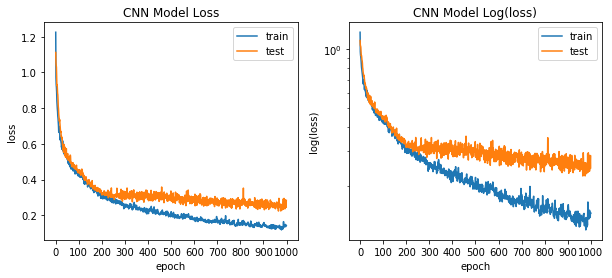

In [117]:
plot_loss_history(CNNmodel1)

In [118]:
cnn = CNN_model(in_dim, out_dim, filtersize=50)
cnn.compile(optimizer="adam", loss="mse")
CNNmodel = cnn.fit(Dtrain_1, aqtrain, validation_data=(Dtest_1, aqtest),
                  epochs=200, batch_size=120)

Train on 881 samples, validate on 221 samples
Epoch 1/200
881/881 [==============================] - 2s 3ms/step - loss: 2.3029 - val_loss: 1.1181
Epoch 2/200
881/881 [==============================] - 2s 2ms/step - loss: 0.9773 - val_loss: 1.0760
Epoch 3/200
881/881 [==============================] - 2s 2ms/step - loss: 0.9596 - val_loss: 1.0351
Epoch 4/200
881/881 [==============================] - 2s 2ms/step - loss: 0.9026 - val_loss: 0.9933
Epoch 5/200
881/881 [==============================] - 2s 2ms/step - loss: 0.8535 - val_loss: 0.9342
Epoch 6/200
881/881 [==============================] - 2s 2ms/step - loss: 0.8000 - val_loss: 0.8915
Epoch 7/200
881/881 [==============================] - 2s 2ms/step - loss: 0.7510 - val_loss: 0.8656
Epoch 8/200
881/881 [==============================] - 2s 2ms/step - loss: 0.7242 - val_loss: 0.8530
Epoch 9/200
881/881 [==============================] - 2s 2ms/step - loss: 0.7041 - val_loss: 0.8210
Epoch 10/200
881/881 [=======================

Epoch 81/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3861 - val_loss: 0.4596
Epoch 82/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3907 - val_loss: 0.4602
Epoch 83/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3873 - val_loss: 0.4252
Epoch 84/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3907 - val_loss: 0.4295
Epoch 85/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3759 - val_loss: 0.4312
Epoch 86/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3700 - val_loss: 0.4307
Epoch 87/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3827 - val_loss: 0.4362
Epoch 88/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3745 - val_loss: 0.4184
Epoch 89/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3762 - val_loss: 0.4162
Epoch 90/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3772

881/881 [==============================] - 1s 2ms/step - loss: 0.2753 - val_loss: 0.3129
Epoch 161/200
881/881 [==============================] - 1s 2ms/step - loss: 0.2778 - val_loss: 0.3040
Epoch 162/200
881/881 [==============================] - 1s 1ms/step - loss: 0.2781 - val_loss: 0.3105
Epoch 163/200
881/881 [==============================] - 1s 2ms/step - loss: 0.2763 - val_loss: 0.3421
Epoch 164/200
881/881 [==============================] - 1s 1ms/step - loss: 0.2963 - val_loss: 0.3017
Epoch 165/200
881/881 [==============================] - 1s 1ms/step - loss: 0.2776 - val_loss: 0.3022
Epoch 166/200
881/881 [==============================] - 1s 1ms/step - loss: 0.2739 - val_loss: 0.3211
Epoch 167/200
881/881 [==============================] - 1s 1ms/step - loss: 0.2732 - val_loss: 0.2988
Epoch 168/200
881/881 [==============================] - 1s 1ms/step - loss: 0.2640 - val_loss: 0.2898
Epoch 169/200
881/881 [==============================] - 1s 2ms/step - loss: 0.2707 - v

In [120]:
# model MSE on training and testing sets

train_mse = cnn.evaluate(Dtrain_1, aqtrain)
test_mse = cnn.evaluate(Dtest_1, aqtest)

print(train_mse, test_mse)

221/221 [==============================] - 0s 533us/step
0.19187352575454755 0.28943463701468247


### Predict Air Quality for training and Testing Sets

In [121]:
import time
start_time = time.time()

aqtrain_pred = cnn.predict(Dtrain_1)
aqtest_pred = cnn.predict(Dtest_1)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:00:00


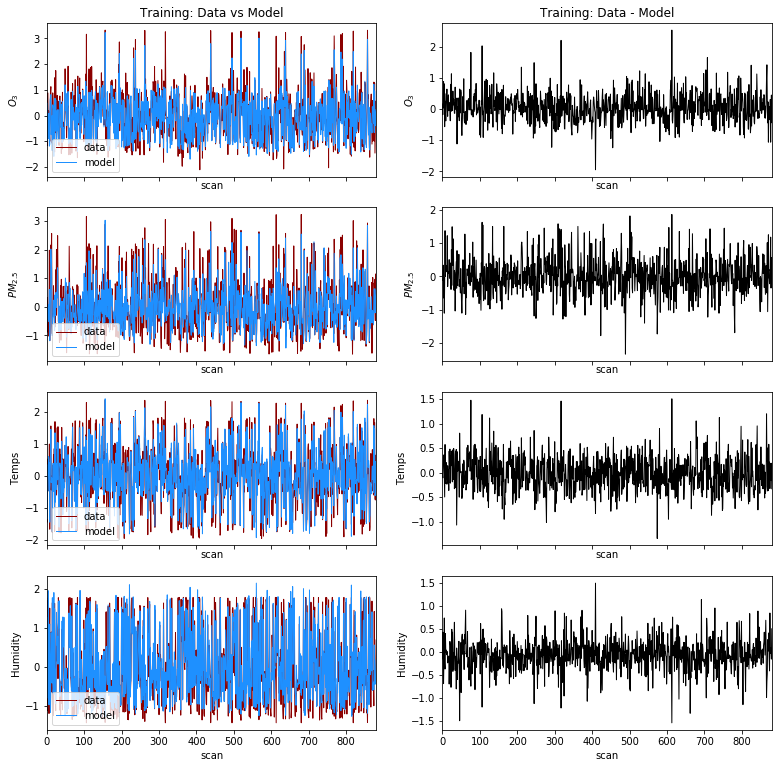

In [122]:
fig, axes = plt.subplots(aq_opth.shape[1], 2, figsize=(13, 13), sharex=True)
labels = [r'$O_3$', r'$PM_{2.5}$', 'Temps', 'Humidity']

axes[0,0].set_title('Training: Data vs Model')
for i in range(aq_opth.shape[1]):
    axes[i,0].plot(aqtrain[:,i], color="darkred",lw=1, label="data")
    axes[i,0].plot(aqtrain_pred[:,i], color="dodgerblue",lw=1, label="model")
    axes[i,0].set_ylabel(labels[i])
    axes[i,0].legend(loc='lower left')
    axes[i,0].set_xlabel("scan")
    axes[i,0].set_xlim(0, aqtrain.shape[0])

axes[0,1].set_title('Training: Data - Model')
for i in range(aq_opth.shape[1]):
    axes[i,1].plot(aqtrain[:,i] - aqtrain_pred[:,i], color="black",lw=1)
    #axes[i,1].plot(aqtrain_pred[:,i], color="dodgerblue",lw=1, label="model")
    axes[i,1].set_ylabel(labels[i])
    #axes[i,1].legend(loc='lower left')
    axes[i,1].set_xlabel("scan")
    axes[i,1].set_xlim(0, aqtrain.shape[0])
    
plt.show()

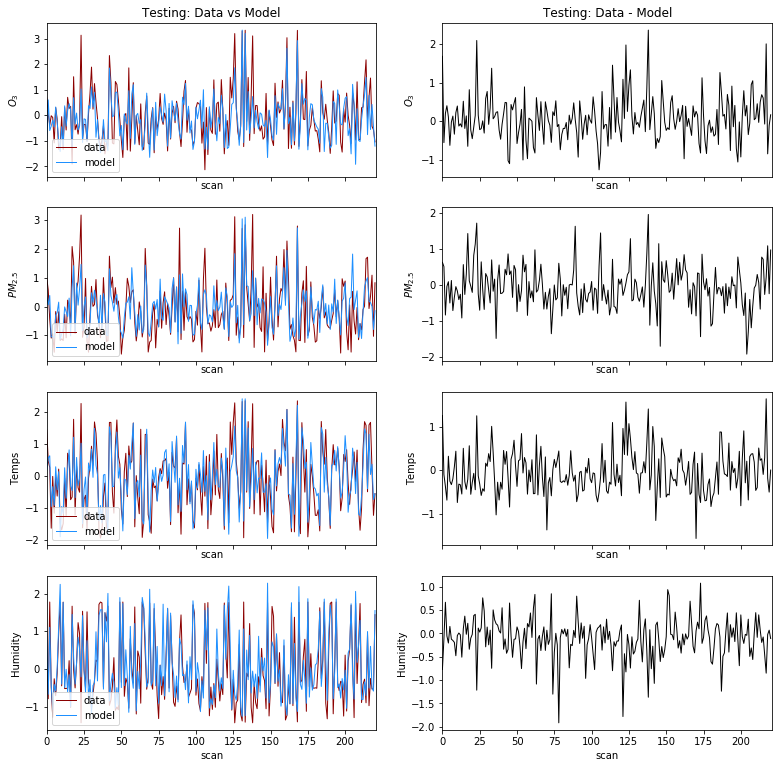

In [123]:
fig, axes = plt.subplots(aq_opth.shape[1], 2, figsize=(13, 13), sharex=True)
labels = [r'$O_3$', r'$PM_{2.5}$', 'Temps', 'Humidity']

axes[0,0].set_title('Testing: Data vs Model')
for i in range(aq_opth.shape[1]):
    axes[i,0].plot(aqtest[:,i], color="darkred",lw=1, label="data")
    axes[i,0].plot(aqtest_pred[:,i], color="dodgerblue",lw=1, label="model")
    axes[i,0].set_ylabel(labels[i])
    axes[i,0].legend(loc='lower left')
    axes[i,0].set_xlabel("scan")
    axes[i,0].set_xlim(0, aqtest.shape[0])

axes[0,1].set_title('Testing: Data - Model')
for i in range(aq_opth.shape[1]):
    axes[i,1].plot(aqtest[:,i] - aqtest_pred[:,i], color="black",lw=1)
    #axes[i,1].plot(aqtrain_pred[:,i], color="dodgerblue",lw=1, label="model")
    axes[i,1].set_ylabel(labels[i])
    #axes[i,1].legend(loc='lower left')
    axes[i,1].set_xlabel("scan")
    axes[i,1].set_xlim(0, aqtest.shape[0])
    
plt.show()

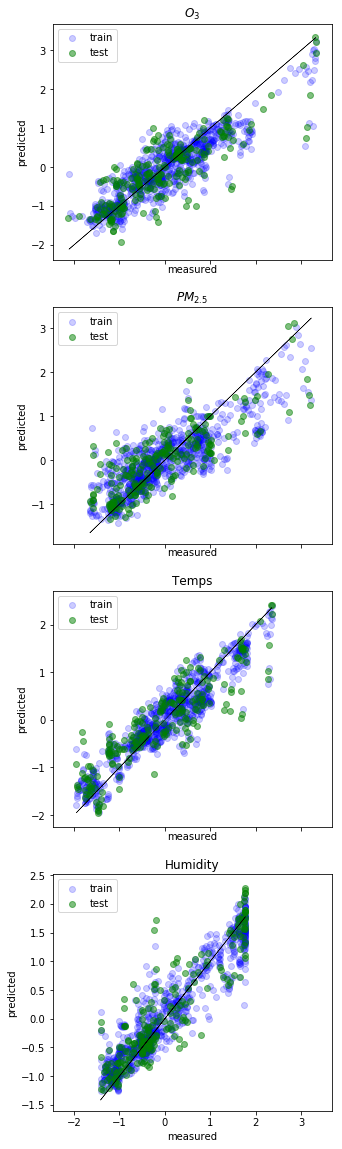

In [124]:
fig, ax = plt.subplots(aq_opth.shape[1], 1, figsize=(5, 20), sharex=True)
labels = [r'$O_3$', r'$PM_{2.5}$', 'Temps', 'Humidity']

for i in range(aq_opth.shape[1]):
    ax[i].set_title(labels[i])
    ax[i].plot(aqtrain[:,i], aqtrain[:,i], color='black', lw=0.5)
    ax[i].scatter(aqtrain[:,i], aqtrain_pred[:,i], c="blue", alpha=0.2, label="train")
    ax[i].scatter(aqtest[:,i], aqtest_pred[:,i], c="green", alpha=0.5, label="test")
    ax[i].set_ylabel('predicted')
    ax[i].set_xlabel('measured')
    ax[i].legend(loc='upper left')
    
plt.show()